In [2]:
# Average window_stride elements together to form a single row
WINDOW_STRIDE = 12

SAMPLE_HOURS = WINDOW_STRIDE / 12.0

# Number of future samples to mean for prediction
PREDICTION_WINDOW = int(24 / SAMPLE_HOURS)

# Length of the windowed sequence
SEQUENCE_LENGTH = int(7*24 / SAMPLE_HOURS)

# Input Features
INPUT_COLUMNS = ['epoch', 'day_of_year', 'hour', 'temp', 'windspd', 'winddir', 'wind_x_dir', 'wind_y_dir', 'no', 'no2', 'nox', 'o3']
OUTPUT_COLUMNS = ['no', 'no2', 'nox', 'o3']

# Fit the sequence to y = mx+b and add the coeff / intercept
REGRESSION_FEATURES = True

# Add variance for each feature in the sequence
STD_FEATURES = True

INPUT_MAP = {value: idx for idx, value in enumerate(INPUT_COLUMNS)}
OUTPUT_MAP = {value: idx for idx, value in enumerate(OUTPUT_COLUMNS)}

NUM_INPUTS = len(INPUT_COLUMNS)
NUM_OUTPUTS = len(OUTPUT_COLUMNS)

In [3]:
import numpy as np

data_sequences = np.load('000_sequences.npy')
data_latlong = np.load('000_latlong_features.npy')
data_sequence_features = np.load('000_sequence_features.npy')


print(data_sequence_features.shape)
labels = np.load('000_labels.npy')
data = data_sequences

print(data.shape)
print(labels.shape)

data_sequences = data_sequences.reshape(data_sequences.shape[0], data_sequences.shape[1]*data_sequences.shape[2])

data = np.concatenate((data_sequences, data_sequence_features), 1)

split = int(data.shape[0] * 0.66)

train_X = data[:split]
train_Y = labels[:split]

val_X = data[split:]
val_Y = labels[split:]

print(train_X.shape)
print(train_Y.shape)

print(val_X.shape)
print(val_Y.shape)

(107900, 27)
(107900, 168, 12)
(107900, 4)
(71214, 2043)
(71214, 4)
(36686, 2043)
(36686, 4)


In [4]:
# Training
import pickle
from sklearn.ensemble import RandomForestRegressor

best_r2 = None

for epoch in range(0, 20):
    regr = RandomForestRegressor(random_state=epoch, max_depth=20, n_estimators=100, n_jobs=-1, verbose=2)
    regr.fit(train_X, train_Y)
    r2 = regr.score(val_X, val_Y)
    
    save = False
    
    if best_r2 is None:
        print("epoch(%d) - R^2: %f" % (epoch+1, r2))
        best_r2 = r2
        save = True
    elif r2 > best_r2:
        print("epoch(%d) - R^2 improved: %f (best: %f)" % (epoch+1, r2, best_r2))
        best_r2 = r2
        save = True
    else:
        print("epoch(%d) - R^2 did not improve: %f (best: %f)" % (epoch+1, r2, best_r2))
    
    if save:
        open('random-forest.best.pickle', 'wb').write(pickle.dumps(regr))

KeyboardInterrupt: 

In [5]:
import pickle
regr = pickle.loads(open('random-forest.best.pickle', 'rb').read())

predictions = regr.predict(np.array(val_X))
print(predictions.shape)
predictions = np.array(predictions)
np.save('000_predictions.npy', predictions)

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.2s


(36686, 4)


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.7s finished


(36686, 168, 12)


<IPython.core.display.Javascript object>


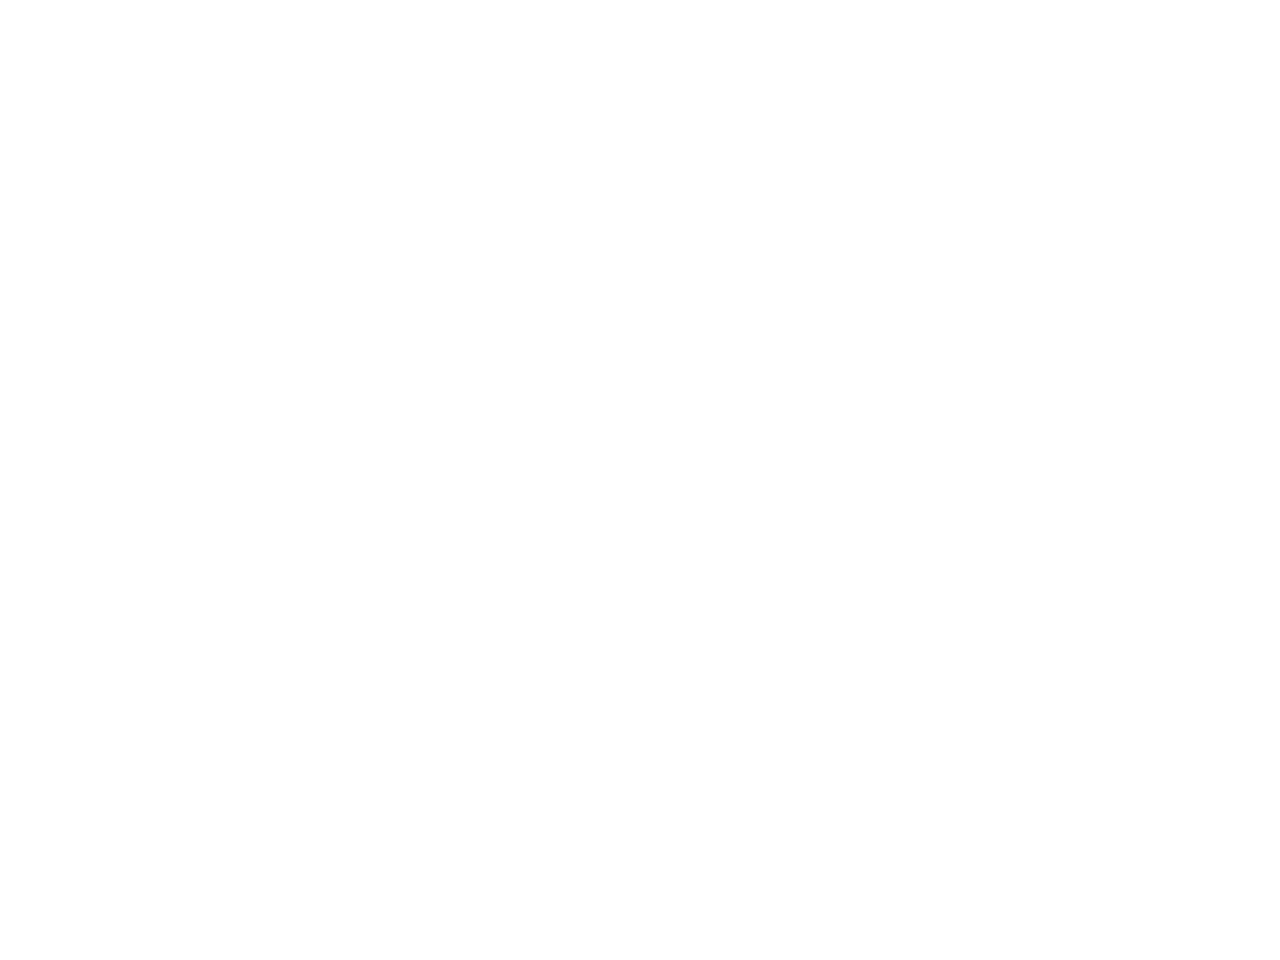

In [5]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.animation as animation

predictions = np.load('000_predictions.npy')

class SubplotAnimation(animation.TimedAnimation):
    def __init__(self, X, Y, P):
        
        tmp = []
        
        for row in range(0, X.shape[0]):
            tmp.append(X[row][:168*12])
                    
        self.X = np.array(tmp).reshape((X.shape[0], 168, 12))
        
        print(self.X.shape)
        
        self.Y = Y
        self.P = P
        
        fig, ax = plt.subplots()

        ax.set_xlabel('Time (hours)')
        ax.set_ylabel('MinMaxScaled Concentration')
        ax.set_title('o3 24 Hour Mean Prediction')
        ax.set_xlim([0, 24*7 + 24])
        ax.legend(['Samples', 'Prediction', 'Actual'])
                
        self.line_24_hour_samples = Line2D([], [], color='black')
        
        self.line_actual = Line2D([], [], color='black')
        self.line_prediction = Line2D([], [], color='purple')

        self._lines_ = [self.line_24_hour_samples,
                       self.line_actual, self.line_prediction]
        
        for line in self._lines_:
            ax.add_line(line)

        animation.TimedAnimation.__init__(self, fig, interval=50, blit=True)
        
    def _draw_frame(self, framedata):
        
        i = framedata
        
        t = np.arange(0, 24*7 + 24)
        
        x_s = np.concatenate([self.X[i][:,INPUT_MAP['o3']], np.full((24,), np.nan)])
        
        y_y = np.concatenate([np.full((24*7,), np.nan), np.full((24,), self.Y[i][OUTPUT_MAP['o3']])])
        y_p = np.concatenate([np.full((24*7,), np.nan), np.full((24,), self.P[i][OUTPUT_MAP['o3']])])

        self.line_24_hour_samples.set_data(t, x_s)
        self.line_actual.set_data(t, y_y)
        self.line_prediction.set_data(t, y_p)

        self._drawn_artists = self._lines_

    def new_frame_seq(self):
        return iter(range(0, self.X.shape[0]))

    def _init_draw(self):
        for l in self._lines_:
            l.set_data([], [])

ani = SubplotAnimation(val_X, val_Y, predictions)
plt.show()

